# Electrical Symbol Detection - Training on Google Colab
Train ResNet50+FPN model with CIoU Loss for multi-class object detection

## 1. Setup Environment

In [1]:
import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU: Not available (will use CPU)")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


## 2. Mount Google Drive (for saving checkpoints)

In [2]:
import sys
import os

# Check if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✓ Google Drive mounted at /content/drive")
    except Exception as e:
        print(f"⚠ Could not mount Google Drive: {e}")
        print("Proceeding without Drive - checkpoints will save locally in /content/")
else:
    print("⚠ Running locally (not on Google Colab)")
    print("Dataset will be saved locally")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted at /content/drive


## 3. Clone Repository

In [3]:
import os
import subprocess

repo_path = '/content/symbol-detection'

if not os.path.exists(repo_path):
    subprocess.run(['git', 'clone', 'https://github.com/BhanukaDev/symbol-detection.git', repo_path], check=True)
    print(f"Repository cloned to {repo_path}")
else:
    print(f"Repository already exists at {repo_path}")
    os.chdir(repo_path)
    subprocess.run(['git', 'pull'], check=True)
    print("Repository updated")

Repository already exists at /content/symbol-detection
Repository updated


## 4. Install Dependencies

In [4]:
import os

# Change to python directory if in Colab
if os.path.exists('/content/symbol-detection/python'):
    os.chdir('/content/symbol-detection/python')
    
    # Install local workspace packages first
    print("Installing local workspace packages...")
    !pip install -e ./floor-grid
    !pip install -e ./effects
    print("✓ Workspace packages installed")

# Install external dependencies
!pip install torch torchvision torchmetrics pycocotools timm

# Install main package
!pip install -e .

Installing local workspace packages...
Obtaining file:///content/symbol-detection/python/floor-grid
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for floor-grid (pyproject.toml) ... done
  Created wheel for floor-grid: filename=floor_grid-0.1.0-py3-none-any.whl size=1196 sha256=78699117b6f3e43fc7361415f221b0fc1e7cda53ed8d7db66595655680a66a57
  Stored in directory: /tmp/pip-ephem-wheel-cache-e2od5sjx/wheels/9e/6b/f6/93c9e88f3c6f9856769f5b99711035582c95144db05c26c467
Successfully built floor-grid
  Attempting uninstall: floor-grid
    Found existing installation: floor-grid 0.1.0
    Uninstalling floor-grid-0.1.0:
      Successfully uninstalled floor-grid-0.1.0
Obtaining file:///content/symbol-detection/python/effects
  Installing build dependencies ... done
  Checking if build backend supports build_editable

## 5. Verify Installation

In [5]:
import sys
import os

# Ensure we're in the right directory
if os.path.exists('/content/symbol-detection/python'):
    os.chdir('/content/symbol-detection/python')
    sys.path.insert(0, '/content/symbol-detection/python/src')

try:
    from symbol_detection.training import Trainer, CIoULoss
    from symbol_detection.dataset.generator import COCODatasetGenerator
    
    print("✓ symbol-detection package imported successfully")
    print("✓ Trainer available")
    print("✓ CIoU Loss available")
    print("✓ COCODatasetGenerator available")
except ImportError as e:
    print(f"✗ Import failed: {e}")
    print("\nReinstalling package...")
    os.chdir('/content/symbol-detection/python')
    !pip install -e .
    print("Please re-run this cell after installation completes.")

✓ symbol-detection package imported successfully
✓ Trainer available
✓ CIoU Loss available
✓ COCODatasetGenerator available


## 6. Mount Dataset Location

In [6]:
import os
import sys
from pathlib import Path

# Determine paths based on environment
IN_COLAB = 'google.colab' in sys.modules
DRIVE_MOUNTED = os.path.exists('/content/drive/MyDrive') if IN_COLAB else False

if IN_COLAB and DRIVE_MOUNTED:
    # Save to Google Drive
    dataset_dir = '/content/drive/MyDrive/symbol-detection/dataset'
    checkpoints_dir = '/content/drive/MyDrive/symbol-detection/checkpoints'
    print("✓ Using Google Drive for storage")
elif IN_COLAB:
    # Fallback to temporary Colab storage
    dataset_dir = '/content/symbol-detection/dataset'
    checkpoints_dir = '/content/symbol-detection/checkpoints'
    print("⚠ Google Drive not mounted - using temporary Colab storage")
else:
    # Local development
    dataset_dir = str(Path.cwd().parent.parent / 'python' / 'dataset')
    checkpoints_dir = str(Path.cwd().parent.parent / 'python' / 'checkpoints')
    print("📁 Using local storage")

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

print(f"Dataset directory: {dataset_dir}")
print(f"Checkpoints directory: {checkpoints_dir}")
print(f"Dataset exists: {os.path.exists(os.path.join(dataset_dir, 'annotations.json'))}")

✓ Using Google Drive for storage
Dataset directory: /content/drive/MyDrive/symbol-detection/dataset
Checkpoints directory: /content/drive/MyDrive/symbol-detection/checkpoints
Dataset exists: True


## 7. Generate Dataset (Optional - if not using pre-generated)

In [24]:
import os
import sys

# Ensure we are in the collection root
os.chdir('/content/symbol-detection/python')

# Manually add library paths to ensure modules are found even if pip install -e isn't fully active in this session
sys.path.insert(0, '/content/symbol-detection/python/floor-grid/src')
sys.path.insert(0, '/content/symbol-detection/python/effects/src')
sys.path.insert(0, '/content/symbol-detection/python/src')

from symbol_detection.dataset.generator import COCODatasetGenerator

print("Generating dataset (200 images)...")

generator = COCODatasetGenerator(
    output_dir=dataset_dir,
    symbols_dir='data/electrical-symbols',
)

# Use the built-in generator with proper COCO annotation conversion
generator.generate_dataset(
    num_images=300,
    rows=(25, 30),              # min, max rows
    cols=(25, 30),              # min, max columns
    cell_size=(20, 25),         # min, max cell size
    apply_symbol_effects=True, # Skip slow effects
    apply_image_effects=True,   # Keep image effects
)

# Save annotations to disk
generator.save_annotations()

num_images = len(os.listdir(os.path.join(dataset_dir, 'images')))
print(f"✓ Dataset generated: {num_images} images")
print(f"✓ Annotations saved: {dataset_dir}/annotations.json")

Generating dataset (200 images)...
Generating 300 dataset images with varied dimensions...
  - Rows range: 25 to 30
  - Cols range: 25 to 30
  - Cell size range: 20 to 25 pixels
  - Symbol effects: enabled
  - Image effects: enabled
Loaded 7 symbol classes:
  - Junction Box: 1 variant(s)
  - Two-way switch: 1 variant(s)
  - Single-pole, one-way switch: 1 variant(s)
  - Light: 1 variant(s)
  - Three-pole, one-way switch: 1 variant(s)
  - Two-pole, one-way switch: 1 variant(s)
  - Duplex Receptacle: 1 variant(s)
[1/300] Generated floor_plan_0000.png (30x27) - 4 rooms, 13 symbols
Loaded 7 symbol classes:
  - Junction Box: 1 variant(s)
  - Two-way switch: 1 variant(s)
  - Single-pole, one-way switch: 1 variant(s)
  - Light: 1 variant(s)
  - Three-pole, one-way switch: 1 variant(s)
  - Two-pole, one-way switch: 1 variant(s)
  - Duplex Receptacle: 1 variant(s)
[2/300] Generated floor_plan_0001.png (26x26) - 5 rooms, 11 symbols
Loaded 7 symbol classes:
  - Junction Box: 1 variant(s)
  - Two-w

## 8. Training Configuration

In [20]:
# Training hyperparameters
# Reduced batch size to 8 to avoid OOM errors (A100 has 40GB but shared environment can be tricky)
training_config = {
    'num_epochs': 50,       # Full training
    'batch_size': 8,        # Reduced from 12 to prevent CUDA OOM
    'learning_rate': 0.005,
    'num_classes': 7,       # Electrical symbols
    'use_ciou_loss': True,  # Complete IoU Loss per paper
    'eval_every_n': 10,     # Evaluate AP metrics every 10 epochs
    'enable_ap_eval': True, # Enable AP50/AP75/mAP evaluation
}

print("Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

import os
# Set allocator config to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(f"\n✓ Batch size set to {training_config['batch_size']} to ensure stability")
print("✓ Configured PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")

Training Configuration:
  num_epochs: 50
  batch_size: 8
  learning_rate: 0.005
  num_classes: 7
  use_ciou_loss: True
  eval_every_n: 10
  enable_ap_eval: True

✓ Batch size set to 8 to ensure stability
✓ Configured PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


## 9. Run Training

In [9]:
import torch
import gc
import importlib
import symbol_detection.training.trainer

# 1. Aggressive Memory Cleanup
# Delete old trainer instance if it exists to free GPU memory immediately
if 'trainer' in globals():
    del trainer

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f"Pre-training memory cleared. Allocated: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

# 2. Reload and Initialize
importlib.reload(symbol_detection.training.trainer)
from symbol_detection.training import Trainer

# Initialize trainer with AP evaluation enabled
trainer = Trainer(
    dataset_dir=dataset_dir,
    output_dir=checkpoints_dir,
    num_classes=training_config['num_classes'],
    batch_size=training_config['batch_size'],
    learning_rate=training_config['learning_rate'],
    num_epochs=training_config['num_epochs'],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    use_ciou_loss=training_config['use_ciou_loss'],
    eval_every_n=training_config['eval_every_n'],
    enable_ap_eval=training_config['enable_ap_eval'],
)

print(f"Trainer initialized on device: {trainer.device}")
print(f"Model: FasterRCNN with ResNet50+FPN backbone")
print(f"CIoU Loss: {training_config['use_ciou_loss']}")
print(f"AP Evaluation: Every {training_config['eval_every_n']} epochs")

Pre-training memory cleared. Allocated: 0.00GB
Using device: cuda
Trainer initialized on device: cuda
Model: FasterRCNN with ResNet50+FPN backbone
CIoU Loss: True
AP Evaluation: Every 10 epochs


In [10]:
import json

# Verify annotations have bbox field before training
ann_file = f'{dataset_dir}/annotations.json'
with open(ann_file, 'r') as f:
    data = json.load(f)

print(f"Checking annotations format...")
print(f"  - Total images: {len(data.get('images', []))}")
print(f"  - Total annotations: {len(data.get('annotations', []))}")
print(f"  - Categories: {len(data.get('categories', []))}")

if data.get('annotations'):
    first_ann = data['annotations'][0]
    print(f"\nFirst annotation sample:")
    print(f"  - Keys: {list(first_ann.keys())}")
    if 'bbox' in first_ann:
        print(f"  - bbox: {first_ann['bbox']} ✓")
    else:
        print(f"  - bbox: MISSING ✗")
        print(f"\n⚠ ERROR: annotations.json does not have 'bbox' field!")
        print(f"Solution: Please re-run cell 7 (Dataset Generation) to regenerate with proper COCO format")
else:
    print("⚠ No annotations found in JSON")

import torch

# Patch the validate method to fix loss computation
def fixed_validate(self, val_loader):
    self.model.train()  # Keep in train mode, disable gradients
    total_loss = 0.0
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(self.device) for img in images]
            targets = [{
                'boxes': t['boxes'].to(self.device),
                'labels': t['labels'].to(self.device),
            } for t in targets]
            
            loss_dict = self.model(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss_dict.values(), torch.tensor(0.0, device=self.device))
            else:
                losses = torch.tensor(0.0, device=self.device)
            
            total_loss += losses.item()
    
    avg_loss = total_loss / len(val_loader)
    self.val_losses.append(avg_loss)
    return avg_loss

# Apply patch
from symbol_detection.training.trainer import Trainer
Trainer.validate = fixed_validate
trainer.validate = fixed_validate.__get__(trainer, Trainer)

print("✓ Trainer validate() method patched")

Checking annotations format...
  - Total images: 300
  - Total annotations: 2846
  - Categories: 7

First annotation sample:
  - Keys: ['id', 'image_id', 'category_id', 'bbox', 'area', 'iscrowd']
  - bbox: [154.0, 23.0, 65.0, 94.0] ✓
✓ Trainer validate() method patched


In [21]:
# Training Execution (Fresh or Resume)
import os
import traceback

# --- CONFIGURATION ---
RESUME_TRAINING = True  # Set to True to resume
RESUME_CHECKPOINT = f'{checkpoints_dir}/model_epoch_80.pth'
TARGET_EPOCHS = 120       # Only used if resuming; extends training to this epoch
# ---------------------

try:
    if RESUME_TRAINING and os.path.exists(RESUME_CHECKPOINT):
        print(f"MODE: Resuming training from {RESUME_CHECKPOINT}")
        
        # 1. Load weights and state
        trainer.load_checkpoint(RESUME_CHECKPOINT, resume_training=True)
        
        # 2. Extend training duration if needed
        if TARGET_EPOCHS > trainer.num_epochs:
            print(f"Extending training from {trainer.num_epochs} to {TARGET_EPOCHS} epochs")
            trainer.num_epochs = TARGET_EPOCHS
            
    elif RESUME_TRAINING:
        print(f"⚠ Checkpoint not found: {RESUME_CHECKPOINT}")
        print("Fallback: Starting FRESH training run instead...")
    else:
        print("MODE: Starting FRESH training run (from scratch)")

    # Start/Continue Training
    trainer.train()
    print("\n✓ Training cycle completed successfully")
    
except Exception as e:
    print(f"✗ Training failed: {e}")
    traceback.print_exc()

MODE: Resuming training from /content/drive/MyDrive/symbol-detection/checkpoints/model_epoch_80.pth
Loaded checkpoint: /content/drive/MyDrive/symbol-detection/checkpoints/model_epoch_80.pth
Extending training from 80 to 120 epochs
Training for 120 epochs (starting from epoch 81)...
Training samples: 240, Validation samples: 60
AP evaluation every 10 epochs

Epoch 81/120 - Train Loss: 0.8093, Val Loss: 0.5006
Epoch 82/120 - Train Loss: 0.4019, Val Loss: 0.3508
Epoch 83/120 - Train Loss: 0.3076, Val Loss: 0.3055
Epoch 84/120 - Train Loss: 0.2531, Val Loss: 0.2469
Epoch 85/120 - Train Loss: 0.2035, Val Loss: 0.2279
Epoch 86/120 - Train Loss: 0.2276, Val Loss: 0.2296
Epoch 87/120 - Train Loss: 0.1587, Val Loss: 0.1979
Epoch 88/120 - Train Loss: 0.1579, Val Loss: 0.2103
Epoch 89/120 - Train Loss: 0.1551, Val Loss: 0.1895
Epoch 90/120 - Train Loss: 0.1409, Val Loss: 0.2198
  Evaluating AP metrics... mAP: 0.832, AP50: 0.993, AP75: 0.982, mAR: 0.864
Saved checkpoint: /content/drive/MyDrive/sym

## 10. Visualize Training Metrics

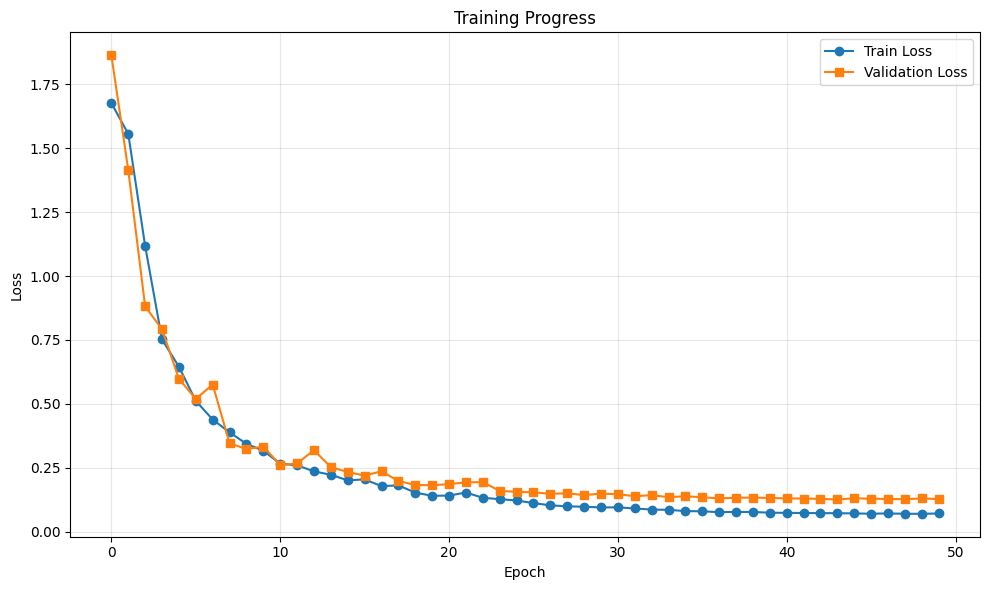

Final train loss: 0.0709
Final val loss: 0.1275


In [12]:
import matplotlib.pyplot as plt
import json
from pathlib import Path

metrics_file = Path(checkpoints_dir) / 'metrics.json'

if metrics_file.exists():
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
    
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Train Loss', marker='o')
    plt.plot(metrics['val_losses'], label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{checkpoints_dir}/training_curve.png', dpi=150)
    plt.show()
    
    print(f"Final train loss: {metrics['train_losses'][-1]:.4f}")
    print(f"Final val loss: {metrics['val_losses'][-1]:.4f}")
else:
    print("Metrics file not found. Training may not have completed.")

## 11. List Saved Checkpoints

In [13]:
from pathlib import Path

checkpoints = list(Path(checkpoints_dir).glob('*.pth'))

if checkpoints:
    print(f"Saved checkpoints ({len(checkpoints)}):")
    for ckpt in sorted(checkpoints):
        size_mb = ckpt.stat().st_size / (1024 * 1024)
        print(f"  {ckpt.name} ({size_mb:.1f} MB)")
    print(f"\nLatest checkpoint: {max(checkpoints, key=lambda x: x.stat().st_mtime).name}")
else:
    print("No checkpoints found")

Saved checkpoints (6):
  model_epoch_10.pth (315.0 MB)
  model_epoch_20.pth (315.0 MB)
  model_epoch_30.pth (315.0 MB)
  model_epoch_40.pth (315.0 MB)
  model_epoch_50.pth (315.0 MB)
  model_epoch_final.pth (315.0 MB)

Latest checkpoint: model_epoch_final.pth


## 12. Download Best Model (Optional)

In [14]:
# The models are already saved in Google Drive (/content/drive/MyDrive/symbol-detection/checkpoints/)
# You can download them directly from Google Drive or use the Colab files interface

print(f"Checkpoints saved to: {checkpoints_dir}")
print("You can download them from Google Drive or use the Colab Files panel on the left")

Checkpoints saved to: /content/drive/MyDrive/symbol-detection/checkpoints
You can download them from Google Drive or use the Colab Files panel on the left
